# EXPRESSO CHURN NOTEBOOK

LOADING THE NECESSARY LIBRARIES

In [1]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [2]:
#Import some libraries
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier as cat
from sklearn.metrics import roc_auc_score,log_loss
from sklearn.metrics import precision_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
gc.collect()

138

In [5]:
#Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/churn prediction"

Mounted at /content/gdrive


In [6]:
path = "/content/gdrive/MyDrive/churn prediction"

In [ ]:
##LOAD THE DATASETS

In [ ]:
#import data
train = pd.read_csv(path+'/Train (10).csv')
test=  pd.read_csv(path+'/Test (8).csv')
submission = pd.read_csv(path+'/SampleSubmission (9).csv')

In [ ]:
train.head(2)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1


In [ ]:
train.shape

(2154048, 19)

In [ ]:
#view the data types in the data data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


In [ ]:
duplicate = train[train.duplicated()]

In [ ]:
duplicate.shape

(0, 19)

EXPLORATORY DATA ANALYSIS

In [ ]:
#Check how many levels are involved in each of the categorical features (object)
print(train['REGION'].value_counts())
plt.figure(figsize=(10,5))
train['REGION'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('REGION')

In [ ]:
print(train['TENURE'].value_counts())
plt.figure(figsize=(10,5))
train['TENURE'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('TENURE')

In [ ]:
print(train['MRG'].value_counts())
plt.figure(figsize=(10,5))
train['MRG'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('MRG')

In [ ]:
#CATEGORICAL DATA
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='TENURE',hue='CHURN',data=train,palette='husl')
plt.title("TENURE VS CHURN")
plt.subplot(1,2,1)
sb.countplot(x='REGION',hue='CHURN',data=train,palette='husl')
plt.title("REGION VS CHURN")
#TOP_PACK VS CHURN
plt.figure(figsize=(20,10))
sb.countplot(x='TOP_PACK',hue='CHURN',data=train)
plt.title("TOP PACK VS CHURN")
#NUMERICAL DATA
#REGULARITY VS CHURN
plt.figure(figsize=(20,10))
sb.countplot(x='REGULARITY',hue='CHURN',data=train)
plt.title("REGULARITY VS CHURN")

In [ ]:
px.histogram(
    train,
    x='REGULARITY',
    template='plotly_dark',
    title='Distribution of REGULARITY - number of times the client is active for 90 days',
    color='CHURN',
    # histnorm='probability'
    barnorm='percent'
)

In [ ]:
fig = px.histogram(
    train.sample(frac=0.5),
    x='TENURE',
    template='plotly_dark',
    title='Distribution of TENURE - duration in the network',
    histnorm='probability'
)
fig.show()

In [ ]:

fig = px.histogram(
    train.loc[train.TENURE!='K > 24 month'],
    x='TENURE',
    template='plotly_dark',
    title='Distribution of TENURE - duration in the network (without K > 24 month)',
    histnorm='probability'
)
fig.show()

In [ ]:
fig = px.histogram(
    train, #.sample(frac=0.8),
    x='REGULARITY',
    facet_row='TENURE',
    template='plotly_dark',
    title='Distribution of TENURE - duration in the network',
    color='CHURN',
    # histnorm='probability',
    height=2000,
    barnorm='percent'
)
fig.show()

In [ ]:
fig = px.histogram(
    train.loc[train.ARPU_SEGMENT<=train.ARPU_SEGMENT.describe()['75%']],
    x='ARPU_SEGMENT',
    facet_row='TENURE',
    template='plotly_dark',
    title='Distribution of REVENUE - monthly income of each client',
    color='CHURN',
    # histnorm='probability'
    barnorm='percent',
    height=2000
)
fig.show()

In [ ]:
px.scatter(
    train.sample(frac=0.1),
    x='REVENUE',
    y='MONTANT',
    color='CHURN'
)

In [ ]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

user_id           2154048
REGION                 15
TENURE                  8
MONTANT              6541
FREQUENCE_RECH        124
REVENUE             38115
ARPU_SEGMENT        16536
FREQUENCE              92
DATA_VOLUME         41551
ON_NET               9885
ORANGE               3168
TIGO                 1316
ZONE1                 613
ZONE2                 487
MRG                     1
REGULARITY             62
TOP_PACK              141
FREQ_TOP_PACK         246
CHURN                   2
dtype: int64

In [ ]:
#Check if the predictor class is balanced 
print(train['CHURN'].value_counts())
plt.figure(figsize=(10,5))
train['CHURN'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Churn')

In [ ]:
#Check summary of numerical fields
train.select_dtypes(include=['int64', 'float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,1397309.0,5532.116998,7111.339421,10.0,1000.0,3000.0,7350.0,470000.0
FREQUENCE_RECH,1397309.0,11.529120,13.274070,1.0,2.0,7.0,16.0,133.0
REVENUE,1428000.0,5510.810334,7187.112880,1.0,1000.0,3000.0,7368.0,532177.0
ARPU_SEGMENT,1428000.0,1836.942894,2395.699954,0.0,333.0,1000.0,2456.0,177392.0
FREQUENCE,1428000.0,13.978141,14.694035,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,1093615.0,3366.450167,13304.463667,0.0,0.0,257.0,2895.0,1823866.0
ON_NET,1367373.0,277.689140,872.688909,0.0,5.0,27.0,156.0,50809.0
ORANGE,1258800.0,95.418711,204.987266,0.0,7.0,29.0,99.0,21323.0
TIGO,864032.0,23.109253,63.578086,0.0,2.0,6.0,20.0,4174.0
ZONE1,169721.0,8.170132,41.169511,0.0,0.0,1.0,3.0,4792.0


In [ ]:
#We are dropping arpu segment since its the same as revenue
#userid and mrg are not important features so we drop them
train.drop(['user_id','MRG','ZONE1','ZONE2'], 1, inplace = True)
test.drop([ 'user_id','MRG','ZONE1','ZONE2'], 1, inplace = True)

DATA MANIPULATION

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
#check for missing values
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_data = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_data

,column_name,percent_missing
REGION,REGION,39.422179
TENURE,TENURE,0.000000
MONTANT,MONTANT,35.111782
FREQUENCE_RECH,FREQUENCE_RECH,35.111782
REVENUE,REVENUE,33.676482
ARPU_SEGMENT,ARPU_SEGMENT,33.676482
FREQUENCE,FREQUENCE,33.676482
DATA_VOLUME,DATA_VOLUME,49.226001
ON_NET,ON_NET,36.508489
ORANGE,ORANGE,41.531386


In [ ]:
# Change each column to its appriopriate datatype
num_cols = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE','FREQUENCE',
       'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'REGULARITY', 'FREQ_TOP_PACK','ARPU_SEGMENT']
cat_cols = [col for col in data.columns if col not in num_cols+['user_id', 'CHURN']]

for col in data.columns:

  if col in cat_cols:
    data[col] = data[col].astype('category')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534175 entries, 0 to 2534174
Data columns (total 15 columns):
 #   Column          Dtype   
---  ------          -----   
 0   REGION          category
 1   TENURE          category
 2   MONTANT         float64 
 3   FREQUENCE_RECH  float64 
 4   REVENUE         float64 
 5   ARPU_SEGMENT    float64 
 6   FREQUENCE       float64 
 7   DATA_VOLUME     float64 
 8   ON_NET          float64 
 9   ORANGE          float64 
 10  TIGO            float64 
 11  REGULARITY      int64   
 12  TOP_PACK        category
 13  FREQ_TOP_PACK   float64 
 14  CHURN           float64 
dtypes: category(3), float64(11), int64(1)
memory usage: 241.7 MB
None


In [ ]:
#HANDLING MISSING DATA

In [ ]:
#Instead of replacing the missing categorical values with mode i replaced them with an "unknown" category

data['REGION'] = data['REGION'].cat.add_categories('Unknown')
data['REGION'].fillna('Unknown', inplace =True) 

data['TOP_PACK'] = data['TOP_PACK'].cat.add_categories('Unknown')
data['TOP_PACK'].fillna('Unknown', inplace =True) 


In [ ]:
#filling missing numerical values  with a "-1" instead of mean. I noticed that there were no negative values in the dataset
for col in data.columns:

  if col in num_cols:
    data[col] = data[col].fillna(-1)

# Confirm that there aren't any missing values
data[data.columns.difference(['CHURN'])].isna().sum()

ARPU_SEGMENT      0
DATA_VOLUME       0
FREQUENCE         0
FREQUENCE_RECH    0
FREQ_TOP_PACK     0
MONTANT           0
ON_NET            0
ORANGE            0
REGION            0
REGULARITY        0
REVENUE           0
TENURE            0
TIGO              0
TOP_PACK          0
dtype: int64

FEATURE ENGINEERING

In [ ]:
data["TENURE_NEW"] = data["TENURE"].map({'K > 24 month':'OVER24','I 18-21 month':'UNDER24','H 15-18 month':'UNDER24','G 12-15 month':'UNDER24','J 21-24 month':'UNDER24','F 9-12 month':'UNDER24','E 6-9 month':'UNDER24','D 3-6 month':'UNDER24',})
print(data['TENURE_NEW'].value_counts())

data["TOPPACK_NEW"] = data["TOP_PACK"].map({'Unknown':'A','All-net 500F=2000F;5d':'A','On net 200F=Unlimited _call24H':'A','Data:490F=1GB,7d':'A',
                                              
                                              'Data: 100 F=40MB,24H':'B','Mixt 250F=Unlimited_call24H':'B','MIXT:500F= 2500F on net _2500F off net;2d':'B','Data:1000F=2GB,30d':'B','All-net 500F =2000F_AllNet_Unlimited':'B','Jokko_Daily':'B',
                                              'Data: 200 F=100MB,24H':'B','IVR Echat_Daily_50F':'B','On-net 500=4000,10d':'B','On-net 500F_FNF;3d':'B','Data:200F=Unlimited,24H':'B','MIXT: 200mnoff net _unl on net _5Go;30d':'B','On-net 1000F=10MilF;10d':'B',
                                              'VAS(IVR_Radio_Daily)':'B','Data:1000F=5GB,7d':'B','Twter_U2opia_Daily':'B','All-net 600F= 3000F ;5d':'B',

                                              'On-net 200F=60mn;1d':'B','All-net 1000=5000;5d':'B','Data:500F=2GB,24H':'B','Twter_U2opia_Weekly':'B','Data:3000F=10GB,30d':'B','MIXT: 390F=04HOn-net_400SMS_400 Mo;4h\t':'B','All-net 500F=1250F_AllNet_1250_Onnet;48h':'B','Data:300F=100MB,2d':'B',
                                              'Data:50F=30MB_24H':'B','All-net 1000F=(3000F On+3000F Off);5d':'B','On net 200F= 3000F_10Mo ;24H':'B','MIXT: 590F=02H_On-net_200SMS_200 Mo;24h\t\t':'B','Data:DailyCycle_Pilot_1.5GB':'B','All-net 300=600;2d':'B','Data:150F=SPPackage1,24H':'B','200=Unlimited1Day':'B',
                                              'Data:1500F=3GB,30D':'B',

                                              'Jokko_promo':'B','Data:700F=1.5GB,7d':'B','On-net 300F=1800F;3d':'B','Facebook_MIX_2D':'B','Data:30Go_V 30_Days':'B','Pilot_Youth4_490':'B','CVM_on-net bundle 500=5000':'B','MROMO_TIMWES_RENEW':'B','Jokko_Monthly':'B','MROMO_TIMWES_OneDAY':'B','WIFI_Family_2MBPS':'B','Data:1500F=SPPackage1,30d':'B',
                                              'Yewouleen_PKG':'B','Twter_U2opia_Monthly':'B','YMGX 100=1 hour FNF, 24H/1 month':'B','New_YAKALMA_4_ALL':'B','Pilot_Youth1_290':'B','Data: 490F=Night,00H-08H':'B','Internat: 1000F_Zone_1;24H\t\t':'B','All-net 5000= 20000off+20000on;30d':'B','SUPERMAGIK_5000':'B','On-net 2000f_One_Month_100H; 30d':'B',
                                              'MIXT:1000F=4250 Off net _ 4250F On net _100Mo; 5d':'B','FNF2 ( JAPPANTE)':'B','SUPERMAGIK_1000':'B','DataPack_Incoming':'B','MIXT: 500F=75(SMS, ONNET, Mo)_1000FAllNet;24h\t\t':'B','MIXT:10000F=10hAllnet_3Go_1h_Zone3;30d\t\t':'B',
                                              'Jokko_Weekly':'B','EVC_500=2000F':'B','WIFI_ Family _4MBPS':'B','Data:700F=SPPackage1,7d':'B','200F=10mnOnNetValid1H':'B','Staff_CPE_Rent':'B','FIFA_TS_daily':'B',

                                              'MIXT: 5000F=80Konnet_20Koffnet_250Mo;30d\t\t':'B','500=Unlimited3Day':'B','IVR Echat_Weekly_200F':'B','All-net 500F=4000F ; 5d':'B','TelmunCRBT_daily':'B','Data: 200F=1GB,24H':'B','MIXT: 4900F= 10H on net_1,5Go ;30d':'B','Mixt : 500F=2500Fonnet_2500Foffnet ;5d':'B','VAS(IVR_Radio_Monthly)':'B','Internat: 1000F_Zone_3;24h\t\t':'B','Internat: 2000F_Zone_2;24H\t\t':'B',
                                              'Incoming_Bonus_woma':'B','EVC_100Mo':'B','VAS(IVR_Radio_Weekly)':'B','CVM_200f=400MB':'B','FNF_Youth_ESN':'B','WIFI_ Family _10MBPS':'B','305155009':'B','1000=Unlimited7Day':'B','Data_EVC_2Go24H':'B','IVR Echat_Monthly_500F':'B',
                                              'NEW_CLIR_PERMANENT_LIBERTE_MOBILE':'B','EVC_JOKKO30':'B','CVM_100F_unlimited':'B','CVM_500f=2GB':'B','EVC_Jokko_Weekly':'B','CVM_100f=200 MB':'B','pack_chinguitel_24h':'B','CVM_On-net 400f=2200F':'B','GPRS_3000Equal10GPORTAL':'B','All-net 500= 4000off+4000on;24H':'B','EVC_700Mo':'B','pilot_offer6':'B',
                                              'CVM_On-net 1300f=12500':'B','APANews_weekly':'B','EVC_MEGA10000F':'B','EVC_4900=12000F':'B','EVC_1Go':'B','pilot_offer7':'B','150=unlimited pilot auto':'B',
                                              'Data_Mifi_10Go_Monthly':'B','200=unlimited pilot auto':'B','pilot_offer4':'B','APANews_monthly':'B','Postpaid FORFAIT 10H Package':'B','301765007':'B','YMGX on-net 100=700F, 24H':'B','1500=Unlimited7Day':'B','SMS Max':'B',
                                              'pilot_offer5':'B','Data:OneTime_Pilot_1.5GB':'B','Package3_Monthly':'B','GPRS_5Go_7D_PORTAL':'B','Data_Mifi_10Go':'B','Data_Mifi_20Go':'B','ESN_POSTPAID_CLASSIC_RENT':'B','FIFA_TS_monthly':'B','FIFA_TS_weekly':'B','Data:1000F=700MB,7d':'B','GPRS_BKG_1000F MIFI':'B',
                                              'NEW_CLIR_TEMPRESTRICTED_LIBERTE_MOBILE':'B','GPRS_PKG_5GO_ILLIMITE':'B','Go-NetPro-4 Go':'B','Data:New-GPRS_PKG_1500F':'B','CVM_150F_unlimited':'B','Jokko_promo':'B','CVM_100f=500 onNet':'B','NEW_CLIR_TEMPALLOWED_LIBERTE_MOBILE':'B',
                                              'MegaChrono_3000F=12500F TOUS RESEAUX':'B','EVC_1000=6000 F':'B','EVC_PACK_2.2Go':'B'})

print(data['TOPPACK_NEW'].value_counts())
data['TENURE'] = data['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month':12,
                                             'J 21-24 month': 21, 'F 9-12 month': 9, 'E 6-9 month':6, 'D 3-6 month':3})
print(data['TENURE'].value_counts())

data['REGION'] = data['REGION'].map({'Unknown': 1, 'DAKAR': 2, 'THIES': 3, 'SAINT-LOUIS':4,
                                             'LOUGA': 5, 'KAOLACK': 6, 'DIOURBEL':7, 'TAMBACOUNDA' :8
                                             , 'KAFFRINE':9, 'KOLDA':10, 'FATICK':11, 'MATAM':12
                                     , 'ZIGUINCHOR':13, 'SEDHIOU':14, 'KEDOUGOU':15})
print(data["REGION"].value_counts())

OVER24     2403551
UNDER24     130624
Name: TENURE_NEW, dtype: int64
A    1750132
B     784043
Name: TOPPACK_NEW, dtype: int64
24    2403551
18      53431
15      30646
12      17577
21      14940
9       10982
6        2137
3         911
Name: TENURE, dtype: int64
1     999027
2     603886
3     211795
4     141255
5     116458
6     113956
7      78603
8      64893
9      51717
10     45548
11     42003
12     34315
13     25847
14      3662
15      1210
Name: REGION, dtype: int64


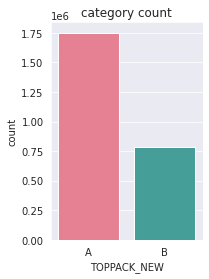

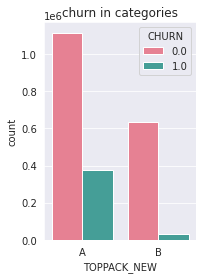

In [ ]:
plt.subplot(1,2,1)
sb.countplot(data['TOPPACK_NEW'],palette='husl')
plt.title("category count")
plt.show()
plt.subplot(1,2,2)
sb.countplot(data['TOPPACK_NEW'], hue = data['CHURN'],palette="husl")
plt.title("churn in categories")
plt.show()

HANDLING OUTLIERS

In [ ]:
#finding outliers and skewness
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['MONTANT'])
plt.title("boxplot of MONTANT")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["MONTANT"])
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['FREQUENCE_RECH'])
plt.title("boxplot of FREQUENCE_RECH")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["FREQUENCE_RECH"])
plt.title("distplot of FREQUENCE_RECH")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['REVENUE'])
plt.title("boxplot of REVENUE")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["REVENUE"])
plt.title("distplot of REVENUE")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['FREQUENCE'])
plt.title("boxplot of FREQUENCE")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["FREQUENCE"])
plt.title("distplot of FREQUENCE")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['ON_NET'])
plt.title("boxplot of ON_NET")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["ON_NET"])
plt.title("distplot of ON_NET")
plt.show()
#finding outliers
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['ORANGE'])
plt.title("boxplot of ORANGE")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["ORANGE"])
plt.title("distplot of ORANGE")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['TIGO'])
plt.title("boxplot of TIGO")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["TIGO"])
plt.title("distplot of TIGO")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['DATA_VOLUME'])
plt.title("boxplot of DATA_VOLUME")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["DATA_VOLUME"])
plt.title("distplot of DATA_VOLUME")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['REGULARITY'])
plt.title("boxplot of REGULARITY")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["REGULARITY"])
plt.title("distplot of REGULARITY")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['FREQ_TOP_PACK'])
plt.title("boxplot of FREQ_TOP_PACK")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["FREQ_TOP_PACK"])
plt.title("distplot of FREQ_TOP_PACK")
plt.show()

In [ ]:
#Instead of dropping the outliers i decided to cap them with the 0.01 and 0.99 percentiles 

data['MONTANT'].loc[data['MONTANT'] > 194931.65199998766]  = 194931.65199998766
data['REVENUE'].loc[data['REVENUE'] > 185138.0468999343]  = 185138.0468999343
data['ON_NET'].loc[data['ON_NET'] > 24417.41113998834]  = 24417.41113998834
data['ORANGE'].loc[data['ORANGE'] > 5587.557379999198]  = 5587.557379999198
data['TIGO'].loc[data['TIGO']> 2563.2156399991363]  = 2563.2156399991363
data['DATA_VOLUME'].loc[data['DATA_VOLUME'] > 899394.3715797728]  = 899394.3715797728

MEAN ENCODING 

In [ ]:
#I noticed that mean encoding the columns ARPU SEGMENT and DATAVOLUME increased the score

In [ ]:

tenure = data.groupby('TENURE').mean()
tenure.drop(['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'FREQUENCE',
      'ON_NET', 'ORANGE', 'TIGO', 'REGULARITY',
       'FREQ_TOP_PACK', 'CHURN'], 1, inplace = True)
cols = []
for i in tenure.columns:
    if i != 'TENURE':
        tenure[i+'_ten_mean_all'] = tenure[i]
        tenure.drop(i, 1, inplace = True)
        cols.append(i+'_ten_mean_all')

data = pd.merge(data, tenure, on='TENURE', how = 'left')


In [ ]:
data.columns

Index(['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK', 'CHURN', 'TENURE_NEW',
       'TOPPACK_NEW', 'ARPU_SEGMENT_ten_mean_all', 'DATA_VOLUME_ten_mean_all'],
      dtype='object')

In [ ]:
region = data.groupby('REGION').mean()
region.drop(['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'FREQUENCE',
      'ON_NET', 'ORANGE', 'TIGO', 'REGULARITY',
       'FREQ_TOP_PACK', 'CHURN', 'ARPU_SEGMENT_ten_mean_all', 'DATA_VOLUME_ten_mean_all'], 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'REGION':
        region[i+'_regi_mean_all'] = region[i]
        region.drop(i, 1, inplace = True)
        cols.append(i+'_regi_mean_all')

data = pd.merge(data, region, on='REGION', how = 'left')


In [ ]:
data.columns

Index(['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK', 'CHURN', 'TENURE_NEW',
       'TOPPACK_NEW', 'ARPU_SEGMENT_ten_mean_all', 'DATA_VOLUME_ten_mean_all',
       'ARPU_SEGMENT_regi_mean_all', 'DATA_VOLUME_regi_mean_all'],
      dtype='object')

In [ ]:
regularity = data.groupby('REGULARITY').mean()
regularity.drop(['MONTANT', 'FREQUENCE_RECH', 'REVENUE',
      'FREQUENCE','ON_NET', 'ORANGE', 'TIGO','FREQ_TOP_PACK', 'CHURN',
        'ARPU_SEGMENT_ten_mean_all', 'DATA_VOLUME_ten_mean_all', 'ARPU_SEGMENT_regi_mean_all',
       'DATA_VOLUME_regi_mean_all'], 1, inplace = True)
cols = []
for i in regularity.columns:
    if i != 'REGULARITY':
        regularity[i+'_regU_mean_all'] = regularity[i]
        regularity.drop(i, 1, inplace = True)
        cols.append(i+'_regU_mean_all')

data = pd.merge(data, regularity, on='REGULARITY', how = 'left')

In [ ]:
data.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,TENURE_NEW,TOPPACK_NEW,ARPU_SEGMENT_ten_mean_all,DATA_VOLUME_ten_mean_all,ARPU_SEGMENT_regi_mean_all,DATA_VOLUME_regi_mean_all,ARPU_SEGMENT_regU_mean_all,DATA_VOLUME_regU_mean_all
0,11,24,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,54,On net 200F=Unlimited _call24H,8.0,0.0,OVER24,A,1228.347883,1685.816569,1251.681356,666.311978,2137.485847,2764.501190
1,1,18,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,Unknown,-1.0,1.0,UNDER24,A,1021.435983,1740.191836,431.672747,968.426280,66.182027,103.791404
2,1,24,3600.0,2.0,1020.0,340.0,2.0,-1.0,90.0,46.0,7.0,17,On-net 1000F=10MilF;10d,1.0,0.0,OVER24,B,1228.347883,1685.816569,431.672747,968.426280,397.292584,525.925875
3,2,24,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,62,"Data:1000F=5GB,7d",11.0,0.0,OVER24,B,1228.347883,1685.816569,2123.911445,3611.699730,4910.538920,7576.829736
4,2,24,1000.0,1.0,985.0,328.0,1.0,-1.0,39.0,24.0,-1.0,11,Mixt 250F=Unlimited_call24H,2.0,0.0,OVER24,B,1228.347883,1685.816569,2123.911445,3611.699730,230.458057,319.507280


In [ ]:
data.shape

(2534175, 23)

In [ ]:
#FEATURE INTERACTIONS
data["REGION"] = data["REGION"].astype('float64')
data["TENURE"] = data["TENURE"].astype('float64')
data["Totalcalls"] = data["ON_NET"]+data["ORANGE"]+data["TIGO"]
data["Totalfrequency"] = data["FREQUENCE_RECH"]+ data["FREQ_TOP_PACK"]
data["regtotfreq"] = data["Totalfrequency"] + data["REGULARITY"]
data["montantfreq"] = data["MONTANT"]*data["Totalfrequency"]

data["revfreq"] = data["REVENUE"]*data["FREQUENCE"]
data["CALLSFREQ"] = data["Totalcalls"]+data["Totalfrequency"]
data["REGIONREG"] = data["REGION"]+data["REGULARITY"]
data["REGIONDATA"] = data["REGION"] + data["DATA_VOLUME"]
data["REGIONFREQ"] = data["REGION"] + data["Totalfrequency"]
data["REGIONCALLS"] = data["REGION"] + data["Totalcalls"]
data["REVREG"] =  data["REVENUE"]/data["REGION"]
data["REGIONMONTANT"] = data["REGION"] + data["MONTANT"]


data['REV_MON'] = data['REVENUE'] - data['MONTANT']
data["FREQMINUSRECH"] = data["FREQUENCE"] - data["FREQUENCE_RECH"]
data["rechminusfreqtoppack"] = data["FREQUENCE_RECH"] - data["FREQ_TOP_PACK"]


data["datareg"] = data["DATA_VOLUME"]/data["REGULARITY"]
data["dataregprod"] = data["DATA_VOLUME"]*data["REGULARITY"]

data['Income_Rech_Freq'] = data["FREQUENCE"] / data["FREQUENCE_RECH"]
data['Income_Active_freq'] = data["FREQUENCE"] / data["REGULARITY"]
data['Refill_Active_freq'] = data["FREQUENCE_RECH"] / data["REGULARITY"]
data["montantcalls"]=data["Totalcalls"]/data["MONTANT"]
data["volume/region"] =  data["DATA_VOLUME"]/data["REGION"] 
data["FREQREGION"] =  data["FREQ_TOP_PACK"]/data["REGION"] 
data["FREQREGION"] =  data["FREQUENCE_RECH"]/data["REGION"] 
data["REVREG"] =  data["REVENUE"]/data["REGION"]
data["MONTANTREG"] = data["MONTANT"]/ data["REGION"] 
data['freq/montant'] =  data['MONTANT']/ data['FREQUENCE']
data['freq/montant'] =  data['MONTANT']/ data['FREQUENCE_RECH']
data['freq/rech'] = data['FREQUENCE'] / data['FREQUENCE_RECH']
data['freq/revenue'] = data['FREQUENCE'] / data['REVENUE']
data['Volume/Montant'] = data["DATA_VOLUME"]/data["MONTANT"]
data["volume/calls"] = data["DATA_VOLUME"]/data["Totalcalls"]/data["DATA_VOLUME"]
data["volume/frequence"] = data["DATA_VOLUME"]/data["FREQUENCE"]
data["volume/rech"] = data["DATA_VOLUME"]/data["FREQUENCE_RECH"]
data["REVMON"] = data["REVENUE"]/data["MONTANT"]


data['TENURE_avg'] = data['TENURE'].map({24: (24+27)/2, 18:(18+21)/2 , 15: (15+18)/2, 12:(12+15)/2,
                                             21: (21+24)/2, 9: (9+12)/2, 6:(6+9)/2, 3:(3+6)/2})
data['TENURE/FREQUENCE_RECH'] = data['TENURE_avg'] / data['FREQUENCE_RECH']
data['TENURE/REGULARITY'] = data['TENURE_avg'] / data['REGULARITY']
data['TENURE/REGION'] = data['TENURE_avg'] / data["REGION"]
data["Connections/Month"] = data["DATA_VOLUME"]/data["TENURE"]
data["Calls/Month"] = data["Totalcalls"]/data["TENURE"]
data["Regularity/Month"] = data["TENURE"]/data["REGULARITY"]
data["Topup/month"] = data["MONTANT"]/data["TENURE"]


data['freq*montant'] = data['FREQUENCE'] * data['MONTANT']
data['freq*rech'] = data['FREQUENCE'] * data['FREQUENCE_RECH']
data['freq*revenue'] = data['FREQUENCE'] * data['REVENUE']
data["REGIONREVPROD"] = data["REGION"] * data["REVENUE"]
data["regtenureavg"] = data['TENURE_avg']*data["REGULARITY"]
data['TotalRefill'] = data["TENURE"]*data["FREQUENCE_RECH"]
data["TotalRevenue"] = data["TENURE"]*data["REVENUE"]
data["TotalIncomeTime"] = data["TENURE"]*data["FREQUENCE"]
data["TotalActivations"] = data["TENURE"]*data["FREQ_TOP_PACK"]


data["regtenure"] = data["TENURE"]+data["REGULARITY"]



data["REGIONTEN"] =  data["TENURE"]/data["REGION"]


In [ ]:
data.describe()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK,CHURN,ARPU_SEGMENT_ten_mean_all,DATA_VOLUME_ten_mean_all,ARPU_SEGMENT_regi_mean_all,DATA_VOLUME_regi_mean_all,ARPU_SEGMENT_regU_mean_all,DATA_VOLUME_regU_mean_all,Totalcalls,Totalfrequency,regtotfreq,montantfreq,revfreq,CALLSFREQ,REGIONREG,REGIONDATA,REGIONFREQ,REGIONCALLS,REVREG,REGIONMONTANT,REV_MON,FREQMINUSRECH,rechminusfreqtoppack,datareg,dataregprod,Income_Rech_Freq,Income_Active_freq,Refill_Active_freq,montantcalls,volume/region,FREQREGION,MONTANTREG,freq/montant,freq/rech,freq/revenue,Volume/Montant,volume/calls,volume/frequence,volume/rech,REVMON,TENURE_avg,TENURE/FREQUENCE_RECH,TENURE/REGULARITY,TENURE/REGION,Connections/Month,Calls/Month,Regularity/Month,Topup/month,freq*montant,freq*rech,freq*revenue,REGIONREVPROD,regtenureavg,TotalRefill,TotalRevenue,TotalIncomeTime,TotalActivations,regtenure,REGIONTEN
count,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.154048e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.157834e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06,2.534175e+06
mean,3.134263e+00,2.357601e+01,3.588207e+03,7.129019e+00,3.652929e+03,1.217618e+03,8.932018e+00,1.704946e+03,1.759935e+02,5.534066e+01,8.668436e+00,2.804838e+01,4.969159e+00,1.875474e-01,1.217618e+03,1.704946e+03,1.217618e+03,1.704946e+03,1.217618e+03,1.704946e+03,2.400026e+02,1.209818e+01,4.014656e+01,1.605284e+05,1.060279e+05,2.521008e+02,3.118265e+01,1.708081e+03,1.523244e+01,2.431368e+02,1.608396e+03,3.591342e+03,6.472203e+01,1.802999e+00,2.159860e+00,4.498072e+01,8.926861e+04,1.199104e+00,1.178254e-01,5.912494e-02,-8.339813e-01,9.158143e+02,2.986865e+00,1.577938e+03,3.632900e+02,1.199104e+00,3.431259e-01,-4.063798e+01,inf,1.336092e+02,1.743748e+02,-8.660968e+00,2.507601e+01,-3.843108e+00,4.458365e+00,1.469507e+01,7.528836e+01,1.026242e+01,4.190314e+00,1.538254e+02,1.038824e+05,2.280475e+02,1.060279e+05,1.322863e+04,7.047019e+02,1.684461e+02,8.637601e+04,2.110067e+02,1.175103e+02,5.162439e+01,1.381442e+01
std,2.935030e+00,2.004357e+00,6.291284e+03,1.224785e+01,6.383619e+03,2.135853e+03,1.389853e+01,9.215050e+03,7.059144e+02,1.628194e+02,4.175038e+01,2.228719e+01,1.064421e+01,3.903504e-01,5.294178e+01,3.045245e+02,6.948899e+02,1.127356e+03,1.439639e+03,2.152235e+03,7.787829e+02,2.228067e+01,4.026233e+01,6.267365e+05,3.324135e+05,7.911295e+02,2.332983e+01,9.214973e+03,2.283102e+01,7.791170e+02,3.401162e+03,6.291566e+03,1.263503e+03,3.799562e+00,5.494511e+00,3.550205e+02,5.344702e+05,1.216766e+00,5.669921e-01,4.949911e-01,4.499581e+01,7.877868e+03,6.439102e+00,3.336893e+03,6.318134e+02,1.216766e+00,4.707347e-01,3.076012e+03,NaN,3.816527e+03,4.357471e+03,3.485410e+02,2.004357e+00,1.700644e+01,7.192426e+00,8.995690e+00,5.539832e+02,3.396934e+01,6.764284e+00,2.784244e+02,3.270177e+05,6.495624e+02,3.324135e+05,2.932250e+04,5.643485e+02,2.905452e+02,1.515710e+05,3.296952e+02,2.526166e+02,2.243785e+01,8.469438e+00
min,1.000000e+00,3.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,5.417464e+02,1.548454e+03,4.316727e+02,2.971483e+02,1.963039e+01,3.812816e+01,-3.0

In [ ]:
data.isnull().sum()

REGION              0
TENURE              0
MONTANT             0
FREQUENCE_RECH      0
REVENUE             0
                   ..
TotalRevenue        0
TotalIncomeTime     0
TotalActivations    0
regtenure           0
REGIONTEN           0
Length: 74, dtype: int64

LABEL ENCODING

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["TOPPACK_NEW"] = le.fit_transform(data["TOPPACK_NEW"])
data["TOP_PACK"] = le.fit_transform(data["TOP_PACK"])
data["TENURE_NEW"] = le.fit_transform(data["TENURE_NEW"])

In [ ]:
data["Newacivationpackage"] = data["TOPPACK_NEW"] * data["FREQ_TOP_PACK"]
data["ActivationPackage"] = data["TOP_PACK"] * data["FREQ_TOP_PACK"]


FREQUENCY ENCODING

In [ ]:
freq_columns = ["ARPU_SEGMENT","DATA_VOLUME","REGION","REGULARITY","TOP_PACK","TOPPACK_NEW","TENURE_NEW"]

In [ ]:
for col in freq_columns:
   data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

ONE HOT ENCODING

In [ ]:
#Encode categorical features
data = pd.get_dummies(data, columns=['TENURE_NEW','TOPPACK_NEW'])
data.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,ARPU_SEGMENT_ten_mean_all,DATA_VOLUME_ten_mean_all,ARPU_SEGMENT_regi_mean_all,DATA_VOLUME_regi_mean_all,ARPU_SEGMENT_regU_mean_all,DATA_VOLUME_regU_mean_all,Totalcalls,Totalfrequency,regtotfreq,montantfreq,revfreq,CALLSFREQ,REGIONREG,REGIONDATA,REGIONFREQ,REGIONCALLS,REVREG,REGIONMONTANT,REV_MON,FREQMINUSRECH,rechminusfreqtoppack,datareg,dataregprod,Income_Rech_Freq,Income_Active_freq,...,freq/montant,freq/rech,freq/revenue,Volume/Montant,volume/calls,volume/frequence,volume/rech,REVMON,TENURE_avg,TENURE/FREQUENCE_RECH,TENURE/REGULARITY,TENURE/REGION,Connections/Month,Calls/Month,Regularity/Month,Topup/month,freq*montant,freq*rech,freq*revenue,REGIONREVPROD,regtenureavg,TotalRefill,TotalRevenue,TotalIncomeTime,TotalActivations,regtenure,REGIONTEN,Newacivationpackage,ActivationPackage,ARPU_SEGMENT_freq,DATA_VOLUME_freq,REGION_freq,REGULARITY_freq,TOP_PACK_freq,TOPPACK_NEW_freq,TENURE_NEW_freq,TENURE_NEW_0,TENURE_NEW_1,TOPPACK_NEW_0,TOPPACK_NEW_1
0,11.0,24.0,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,54,109,8.0,0.0,1228.347883,1685.816569,1251.681356,666.311978,2137.485847,2764.501190,435.0,23.0,77.0,97750.0,72267.0,458.0,65.0,15.0,34.0,446.0,386.454545,4261.0,1.0,2.0,7.0,0.074074,216.0,1.133333,0.314815,...,283.333333,1.133333,0.003999,0.000941,0.002299,0.235294,0.266667,1.000235,25.5,1.70,0.472222,2.318182,0.166667,18.125000,0.444444,177.083333,72250.0,255.0,72267.0,46761.0,1377.0,360.0,102024.0,408.0,192.0,78.0,2.181818,0.0,872.0,0.000383,2.610317e-03,0.016575,0.012268,0.070825,0.690612,0.948455,1,0,1,0
1,1.0,18.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,128,-1.0,1.0,1021.435983,1740.191836,431.672747,968.426280,66.182027,103.791404,-3.0,-2.0,2.0,2.0,1.0,-5.0,5.0,0.0,-1.0,-2.0,-1.000000,0.0,0.0,0.0,0.0,-0.250000,-4.0,1.000000,-0.250000,...,1.000000,1.000000,1.000000,1.000000,-0.333333,1.000000,1.000000,1.000000,19.5,-19.50,4.875000,19.500000,-0.055556,-0.166667,4.500000,-0.055556,1.0,1.0,1.0,-1.0,78.0,-18.0,-18.0,-18.0,-18.0,22.0,18.000000,-0.0,-128.0,0.336765,4.922600e-01,0.394222,0.031739,0.418824,0.690612,0.051545,0,1,1,0
2,1.0,24.0,3600.0,2.0,1020.0,340.0,2.0,-1.0,90.0,46.0,7.0,17,110,1.0,0.0,1228.347883,1685.816569,431.672747,968.426280,397.292584,525.925875,143.0,3.0,20.0,10800.0,2040.0,146.0,18.0,0.0,4.0,144.0,1020.000000,3601.0,-2580.0,0.0,1.0,-0.058824,-17.0,1.000000,0.117647,...,1800.000000,1.000000,0.001961,-0.000278,0.006993,-0.500000,-0.500000,0.283333,25.5,12.75,1.500000,25.500000,-0.041667,5.958333,1.411765,150.000000,7200.0,4.0,2040.0,1020.0,433.5,48.0,24480.0,48.0,24.0,41.0,24.000000,1.0,110.0,0.000232,4.922600e-01,0.394222,0.011382,0.008550,0.309388,0.948455,1,0,0,1
3,2.0,24.0,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,62,35,11.0,0.0,1228.347883,1685.816569,2123.911445,3611.699730,4910.538920,7576.829736,145.0,26.0,88.0,351000.0,243036.0,171.0,64.0,43806.0,28.0,147.0,6751.000000,13502.0,2.0,3.0,4.0,706.516129,2715848.0,1.200000,0.290323,...,900.000000,1.200000,0.001333,3.244741,0.006897,2433.555556,2920.266667,1.000148,25.5,1.70,0.411290,12.750000,1825.166667,6.041667,0.387097,562.500000,243000.0,270.0,243036.0,27004.0,1581.0,360.0,324048.0,432.0,264.0,86.0,12.000000,11.0,385.0,0.000082,7.892115e-07,0.238297,0.077340,0.006762,0.309388,0.948455,1,0,0,1
4,2.0,24.0,1000.0,1.0,985.0,328.0,1.0,-1.0,39.0,24.0,-1.0,11,102,2.0,0.0,1228.347883,1685.816569,2123.911445,3611.699730,230.458057,319.507280,62.0,3.0,14.0,3000.0,985.0,65.0,13.0,1.0,5.0,64.0,492.500000,1002.0,-15.0,0.0,-1.0,-0.090909,-11.0,1.000000,0.090909,...,1000.000000,1.000000,0.001015,-0.001000,0.016129,-1.000000,-1.000000,0.985000,25.5,25.50,2.318182,12.750000,-0.041667,2.583333,2.181818,41.666667,1000.0,1.0,985.0,1970.0,280.5,24.0,23640.0,24.0,48.0,35.0,12.000000,2.0,204.0,0.000354,4.922600e-01,0.238297,0.015016,0.031360,0.309388,0.948455,1,0,0,1


FEATURE SELECTION

In [ ]:
# # Separate train and test data from the combined dataframe
# train_df = data[:ntrain]
# test_df = data[ntrain:]

# # Check the shapes of the split dataset
# train_df.shape, test_df.shape

In [ ]:
# # Select main columns to be used in training
# main_cols = data.columns.difference(['user_id', 'CHURN','montantcalls'])
# X = train_df[main_cols]
# y = train_df.CHURN
# # Create the model with several hyperparameters
# model = lgb.LGBMClassifier(random_state=103, n_estimators=1000, metric='AUC', learning_rate=0.04, subsample=0.7,
#                          colsample_bytree=0.8, num_leaves=64, reg_alpha=4, min_child_samples=5,subsample_freq=2)
# #
# # Split into training and validation set
# import random
# random.seed(123)
# #
# train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.3, random_state = 47,stratify=y)
# # Train using early stopping
# model.fit(train_features, train_y, 
#           verbose = 200)

In [ ]:
# pd.options.display.max_rows = 2200
# #define a function to create variable importance dataframe
# def get_lgbm_varimp(model, train_columns, max_vars=100):
    
#     # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
#     # so using feature_importances_ property
#     feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
#     cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

#     cv_varimp_df.columns = ['feature_name', 'varimp (%)']

#     cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

#     cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

#     return cv_varimp_df
# #
# get_lgbm_varimp(model, X.columns)

In [ ]:
train = data[:ntrain].copy()
#train.drop_duplicates(inplace = True, ignore_index=True)
target = train.CHURN.copy()
train.drop('CHURN', axis=1, inplace=True)

test = data[ntrain:].copy()
test.drop('CHURN', axis=1, inplace=True)
test = test.reset_index(drop=True)

In [ ]:
train.shape,test.shape

((2154048, 84), (380127, 84))

In [ ]:
X=train

In [ ]:
#drop irrelevant columns/variables from X features
columns = [
'TENURE_NEW_0',
'TENURE_NEW_1',
'TENURE_NEW_freq',
'TOPPACK_NEW_freq',
'volume/calls'	
]
#
X.drop(columns, inplace=True, axis=1)

In [ ]:
#Dropping highly correlated attributes 
corr = X.corr()
# sns.heatmap(corr)
#
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X = X[selected_columns]

In [ ]:
train = train[selected_columns]
test = test[selected_columns]
train.shape,test.shape

((2154048, 45), (380127, 45))

In [ ]:
test.isnull().sum()

REGION                        0
TENURE                        0
MONTANT                       0
FREQUENCE_RECH                0
DATA_VOLUME                   0
ON_NET                        0
ORANGE                        0
TIGO                          0
REGULARITY                    0
TOP_PACK                      0
FREQ_TOP_PACK                 0
ARPU_SEGMENT_ten_mean_all     0
DATA_VOLUME_ten_mean_all      0
ARPU_SEGMENT_regi_mean_all    0
DATA_VOLUME_regi_mean_all     0
ARPU_SEGMENT_regU_mean_all    0
montantfreq                   0
REVREG                        0
REV_MON                       0
FREQMINUSRECH                 0
rechminusfreqtoppack          0
datareg                       0
Income_Rech_Freq              0
Income_Active_freq            0
Refill_Active_freq            0
montantcalls                  0
FREQREGION                    0
freq/montant                  0
freq/revenue                  0
Volume/Montant                0
volume/frequence              0
volume/r

# MODELLING 

In [ ]:
from sklearn.model_selection import StratifiedKFold


In [ ]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 20
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sb.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

In [ ]:
# xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
#                           eta = 0.99,
#                           max_depth = 6, 
#                           n_estimators = 5000,
#                           reg_lambda = 500,
#                           sub_sample = 0.8,
#                           colsample_bytree = 0.8, tree_method='gpu_hist', gpu_id=0)

# func_= func(train, target, test, xgboost, 'xgboost', 1000)
# val_p4, test_p4, model4 = func_()

================================Fold1====================================
0:	learn: 0.9249059	test: 0.9247136	best: 0.9247136 (0)	total: 96.1ms	remaining: 16m
50:	learn: 0.9299318	test: 0.9297037	best: 0.9297037 (50)	total: 4.07s	remaining: 13m 13s
100:	learn: 0.9305401	test: 0.9303120	best: 0.9303120 (100)	total: 8.03s	remaining: 13m 7s
150:	learn: 0.9308649	test: 0.9305885	best: 0.9305885 (150)	total: 12s	remaining: 13m
200:	learn: 0.9310615	test: 0.9307713	best: 0.9307713 (200)	total: 15.9s	remaining: 12m 55s
250:	learn: 0.9311991	test: 0.9308743	best: 0.9308743 (250)	total: 19.9s	remaining: 12m 53s
300:	learn: 0.9312899	test: 0.9309235	best: 0.9309235 (296)	total: 23.9s	remaining: 12m 49s
350:	learn: 0.9313670	test: 0.9309822	best: 0.9309822 (350)	total: 27.9s	remaining: 12m 46s
400:	learn: 0.9314304	test: 0.9310328	best: 0.9310328 (400)	total: 31.9s	remaining: 12m 42s
450:	learn: 0.9314843	test: 0.9310970	best: 0.9310970 (450)	total: 35.8s	remaining: 12m 37s
500:	learn: 0.9315374	

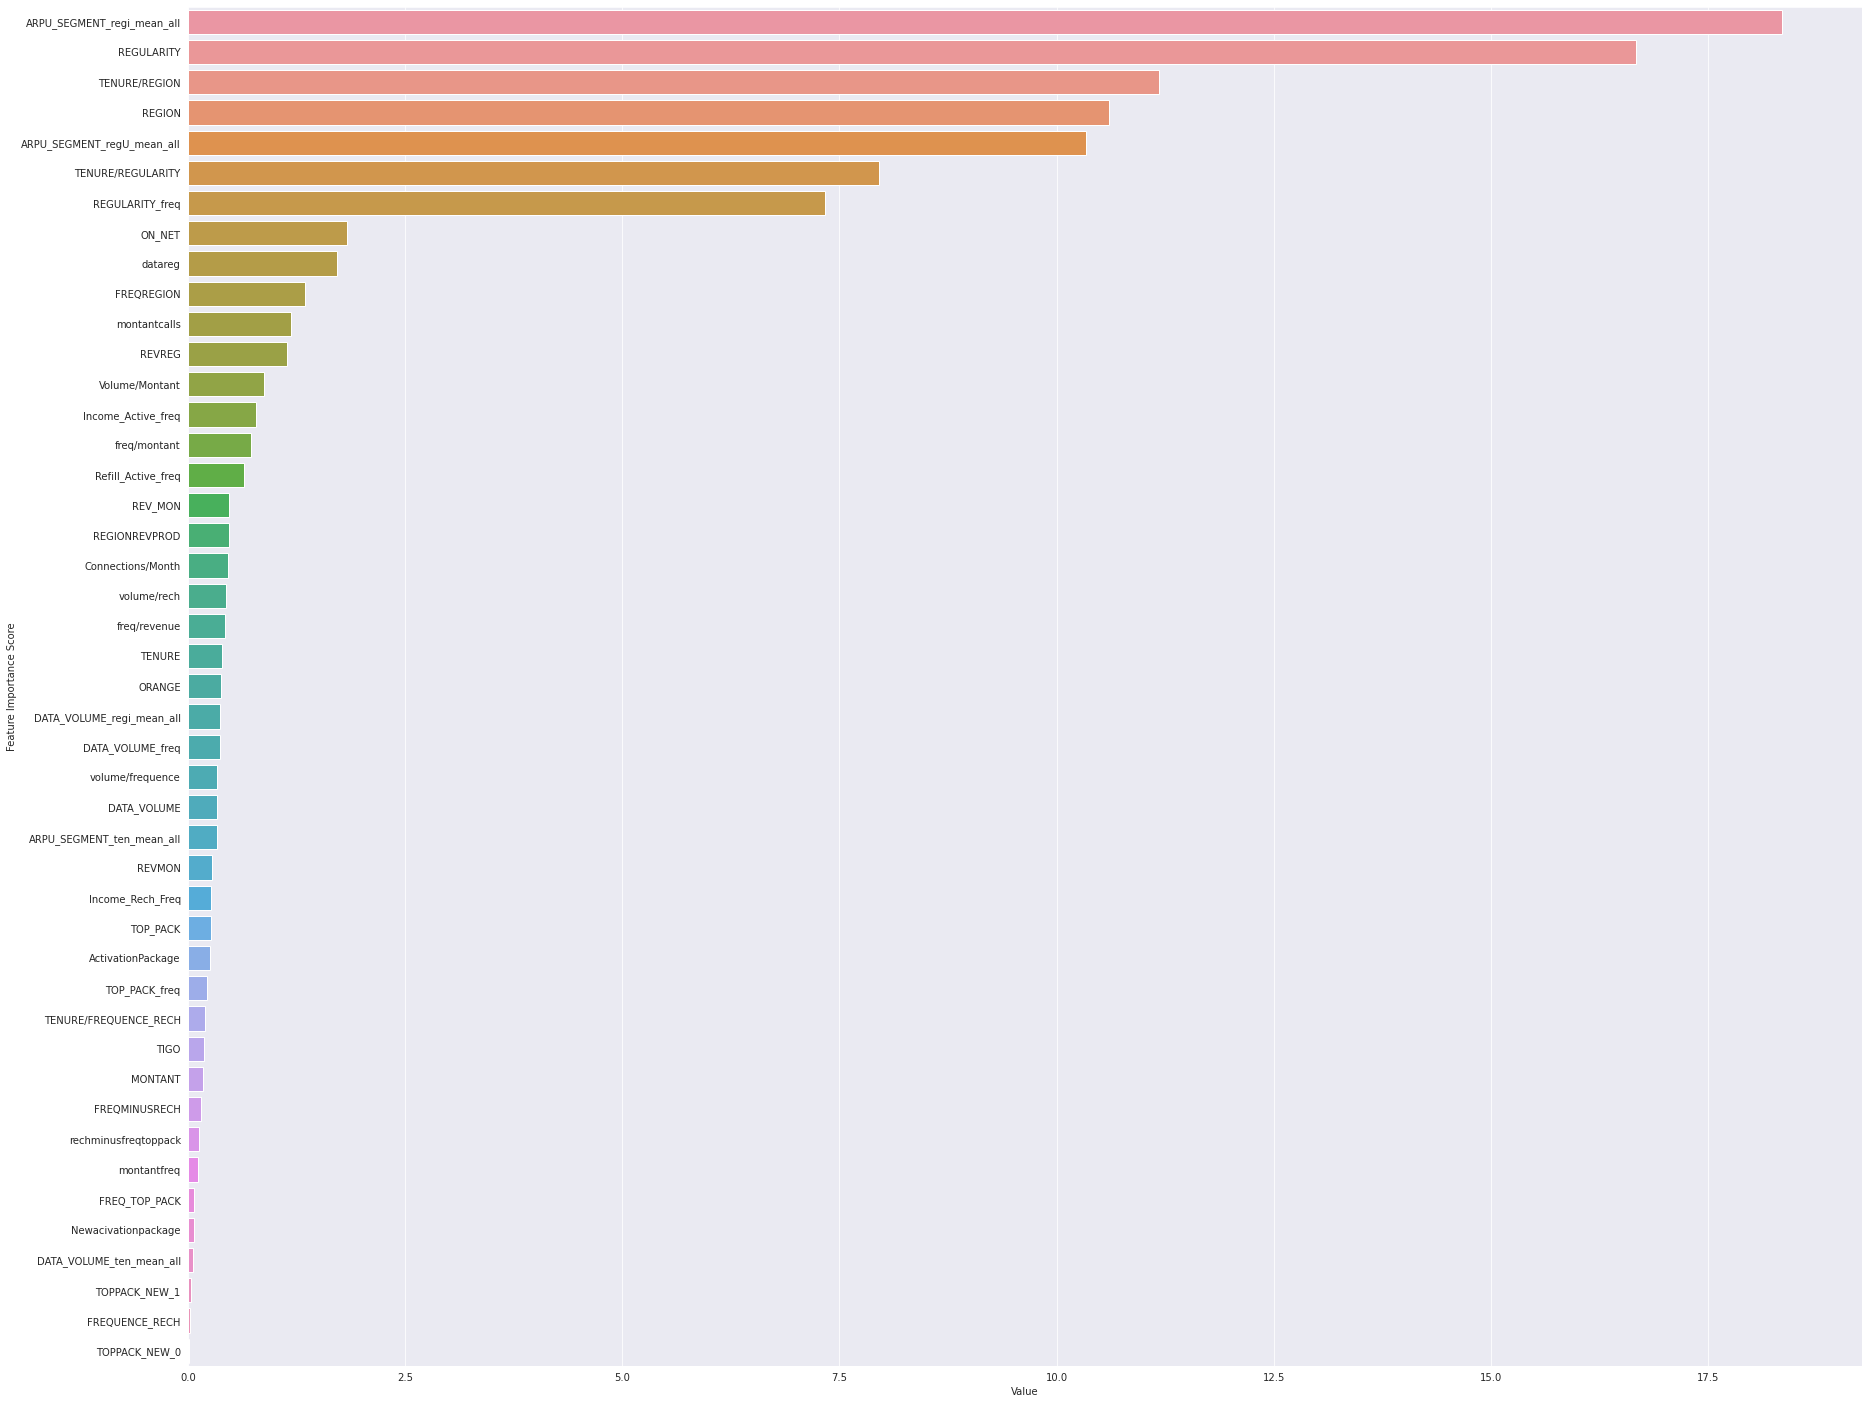

0.9316761921121351 0.9325669407268183 0.0008498494183368011


In [ ]:
catboost = cat(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1')

func_= func(train, target, test, catboost, 'catboost', 16)
val_p1, test_p1, model1 = func_()

Streaming output truncated to the last 5000 lines.
[34]	valid_0's auc: 0.929229
[35]	valid_0's auc: 0.929247
[36]	valid_0's auc: 0.929261
[37]	valid_0's auc: 0.929275
[38]	valid_0's auc: 0.92928
[39]	valid_0's auc: 0.929288
[40]	valid_0's auc: 0.929313
[41]	valid_0's auc: 0.929187
[42]	valid_0's auc: 0.929199
[43]	valid_0's auc: 0.929212
[44]	valid_0's auc: 0.929215
[45]	valid_0's auc: 0.929357
[46]	valid_0's auc: 0.929367
[47]	valid_0's auc: 0.92937
[48]	valid_0's auc: 0.929387
[49]	valid_0's auc: 0.92939
[50]	valid_0's auc: 0.929393
[51]	valid_0's auc: 0.929434
[52]	valid_0's auc: 0.92944
[53]	valid_0's auc: 0.929447
[54]	valid_0's auc: 0.929448
[55]	valid_0's auc: 0.929467
[56]	valid_0's auc: 0.929475
[57]	valid_0's auc: 0.929479
[58]	valid_0's auc: 0.929486
[59]	valid_0's auc: 0.929484
[60]	valid_0's auc: 0.929479
[61]	valid_0's auc: 0.929494
[62]	valid_0's auc: 0.929503
[63]	valid_0's auc: 0.929514
[64]	valid_0's auc: 0.929512
[65]	valid_0's auc: 0.929521
[66]	valid_0's auc: 0.929

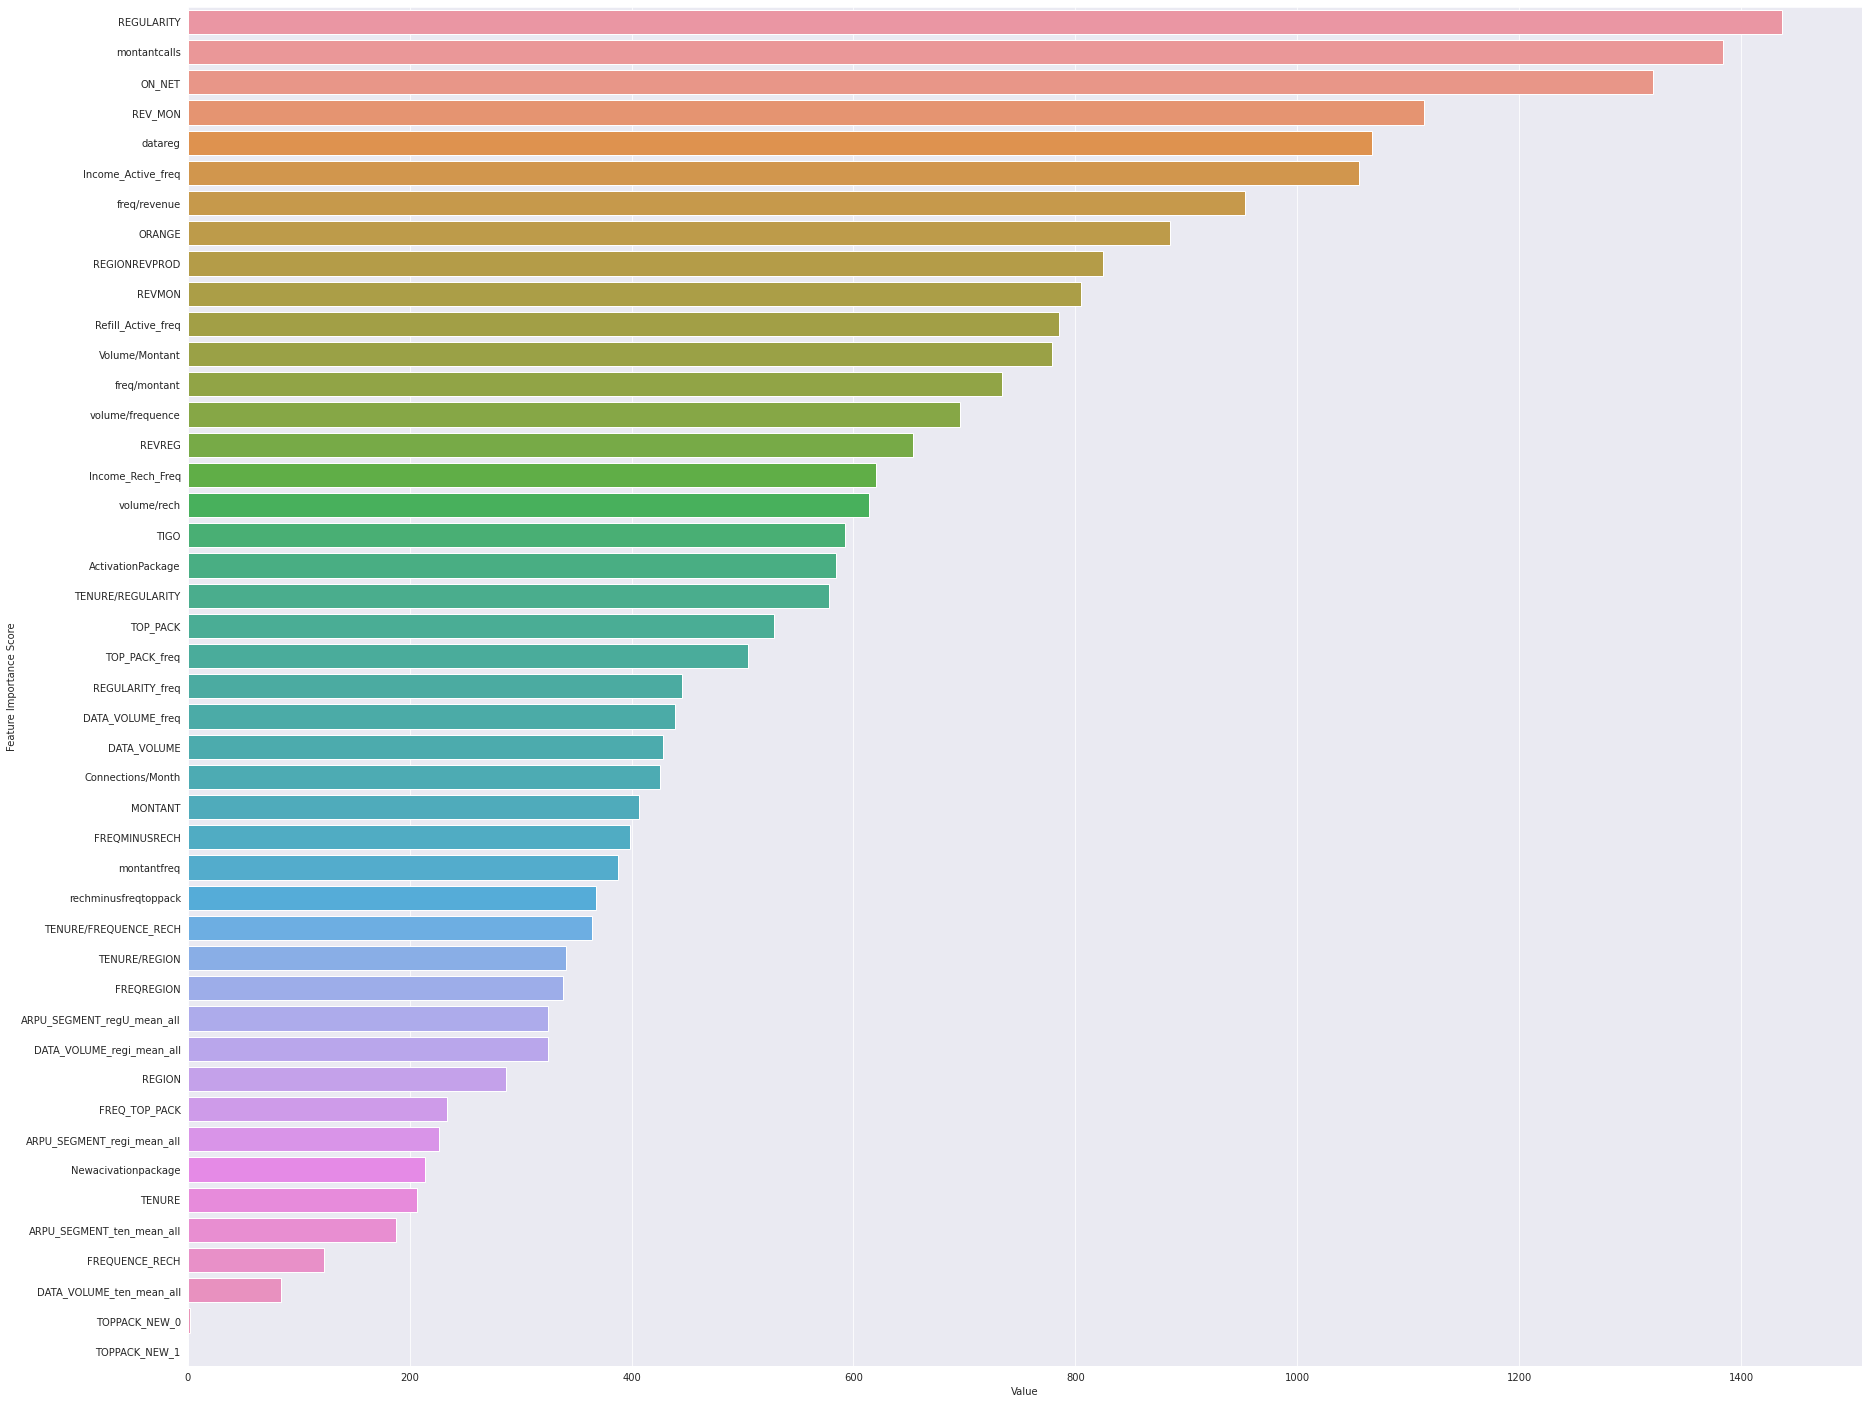

0.9316352225999573 0.9328092829606762 0.0008587273313825704


In [ ]:
lgb_model = lgb.LGBMClassifier( n_estimators=1000, metric='AUC', learning_rate=0.04, subsample=0.7,
                         colsample_bytree=0.8, num_leaves=64, reg_alpha=4, min_child_samples=5,subsample_freq=2)

func_= func(train, target, test, lgb_model, 'lgbm',64)
val_p3, test_p3, model3 = func_()

STACKING

In [ ]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1,val_p3))

stack_p = np.column_stack((test_p1,test_p3))

predict = LinearRegression().fit(stack, target).predict(stack_p)

SUBMISSION

In [ ]:
submission['CHURN'] = predict
submission.to_csv('solution_20lgcat.csv',index=False)